# **INTRODUCTION:**

This is a very simple implementation of XGBoost for this data. One of the great features of XGBoost is that it has built in functionality to easily see the top features F score. This means we can add a lot of features to the model and then easily see what really makes a difference in prediction. This is extremely important for this challenge since it is not really about the leaderboard results, it is more about determining useful features for models. 

I am working on collecting publicly available datasets to continue to add in new variables (features) to see what might be useful.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.cloud import bigquery

# Load the data

In [2]:
train = pd.read_csv("../input/covid19-global-forecasting-week-1/train.csv")
test = pd.read_csv("../input/covid19-global-forecasting-week-1/test.csv")

In [3]:
test

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0000,65.0000,2020-03-12
1,2,NaN,Afghanistan,33.0000,65.0000,2020-03-13
2,3,NaN,Afghanistan,33.0000,65.0000,2020-03-14
3,4,NaN,Afghanistan,33.0000,65.0000,2020-03-15
4,5,NaN,Afghanistan,33.0000,65.0000,2020-03-16
...,...,...,...,...,...,...
12207,12208,NaN,Zambia,-15.4167,28.2833,2020-04-19
12208,12209,NaN,Zambia,-15.4167,28.2833,2020-04-20
12209,12210,NaN,Zambia,-15.4167,28.2833,2020-04-21
12210,12211,NaN,Zambia,-15.4167,28.2833,2020-04-22


# Add Weather Data

We will be doing this using the technique outlined in the great notebook https://www.kaggle.com/davidbnn92/weather-data?scriptVersionId=30695168

In [4]:
%%time
client = bigquery.Client()
dataset_ref = client.dataset("noaa_gsod", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

tables = list(client.list_tables(dataset))

table_ref = dataset_ref.table("stations")
table = client.get_table(table_ref)
stations_df = client.list_rows(table).to_dataframe()

table_ref = dataset_ref.table("gsod2020")
table = client.get_table(table_ref)
twenty_twenty_df = client.list_rows(table).to_dataframe()

stations_df['STN'] = stations_df['usaf'] + '-' + stations_df['wban']
twenty_twenty_df['STN'] = twenty_twenty_df['stn'] + '-' + twenty_twenty_df['wban']

cols_1 = ['STN', 'mo', 'da', 'temp', 'min', 'max', 'stp', 'wdsp', 'prcp', 'fog']
cols_2 = ['STN', 'country', 'state', 'call', 'lat', 'lon', 'elev']
weather_df = twenty_twenty_df[cols_1].join(stations_df[cols_2].set_index('STN'), on='STN')

weather_df.tail(10)

Using Kaggle's public dataset BigQuery integration.
CPU times: user 2min 12s, sys: 4.3 s, total: 2min 17s
Wall time: 5min 17s


,STN,mo,da,temp,min,max,stp,wdsp,prcp,fog,country,state,call,lat,lon,elev
929644,477040-99999,01,12,44.1,42.8,48.2,999.9,7.7,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
929645,477040-99999,01,19,45.0,37.4,51.8,999.9,7,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
929646,477040-99999,02,08,37.3,32.0,44.6,999.9,13.8,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
929647,477040-99999,02,17,38.9,32.0,44.6,999.9,17,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
929648,477040-99999,03,15,41.6,33.8,53.6,999.9,10.9,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
929649,476040-99999,03,05,39.8,37.4,46.8,13.3,12.6,0.12,1,JA,None,None,37.900,139.017,+0005.7
929650,710790-99999,01,05,5.1,2.3,6.8,980.8,5.5,0.18,1,CA,None,CYTH,55.801,-97.864,+0222.2
929651,711210-99999,02,20,22.0,12.2,37.4,935.2,7.5,0.02,1,CA,None,CYED,53.667,-113.467,+0688.0
929652,722700-23044,02,11,48.4,36.0,60.1,877.6,6.9,0.19,1,US,TX,KELP,31.811,-106.376,+1194.2
929653,722593-03985,01,10,68.1,66.2,69.8,984.7,12.6,99.99,1,US,TX,KFWS,32.565,-97.308,+0213.4


In [5]:
from scipy.spatial.distance import cdist

weather_df['day_from_jan_first'] = (weather_df['da'].apply(int)
                                   + 31*(weather_df['mo']=='02') 
                                   + 60*(weather_df['mo']=='03')
                                   + 91*(weather_df['mo']=='04')  
                                   )

mo = train['Date'].apply(lambda x: x[5:7])
da = train['Date'].apply(lambda x: x[8:10])
train['day_from_jan_first'] = (da.apply(int)
                               + 31*(mo=='02') 
                               + 60*(mo=='03')
                               + 91*(mo=='04')  
                              )

C = []
for j in train.index:
    df = train.iloc[j:(j+1)]
    mat = cdist(df[['Lat','Long', 'day_from_jan_first']],
                weather_df[['lat','lon', 'day_from_jan_first']], 
                metric='euclidean')
    new_df = pd.DataFrame(mat, index=df.Id, columns=weather_df.index)
    arr = new_df.values
    new_close = np.where(arr == np.nanmin(arr, axis=1)[:,None],new_df.columns,False)
    L = [i[i.astype(bool)].tolist()[0] for i in new_close]
    C.append(L[0])
    
train['closest_station'] = C

train = train.set_index('closest_station').join(weather_df[['temp', 'min', 'max', 'stp', 'wdsp', 'prcp', 'fog']], ).reset_index().drop(['index'], axis=1)
train.sort_values(by=['Id'], inplace=True)
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,day_from_jan_first,temp,min,max,stp,wdsp,prcp,fog
7895,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,22,42.6,33.6,54.9,999.9,9.4,0.00,0
15727,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,23,42.0,32.7,55.9,999.9,14.9,99.99,1
17706,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,24,40.1,36.9,43.2,999.9,10.4,0.17,1
15728,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,25,46.0,37.9,56.3,999.9,6.1,0.57,1
15729,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,26,42.8,36.1,53.1,999.9,10.8,0.00,1


In [6]:
from scipy.spatial.distance import cdist

weather_df['day_from_jan_first'] = (weather_df['da'].apply(int)
                                   + 31*(weather_df['mo']=='02') 
                                   + 60*(weather_df['mo']=='03')
                                   + 91*(weather_df['mo']=='04')  
                                   )

mo = test['Date'].apply(lambda x: x[5:7])
da = test['Date'].apply(lambda x: x[8:10])
test['day_from_jan_first'] = (da.apply(int)
                               + 31*(mo=='02') 
                               + 60*(mo=='03')
                               + 91*(mo=='04')  
                              )

C = []
for j in test.index:
    df = test.iloc[j:(j+1)]
    mat = cdist(df[['Lat','Long', 'day_from_jan_first']],
                weather_df[['lat','lon', 'day_from_jan_first']], 
                metric='euclidean')
    new_df = pd.DataFrame(mat, index=df.ForecastId, columns=weather_df.index)
    arr = new_df.values
    new_close = np.where(arr == np.nanmin(arr, axis=1)[:,None],new_df.columns,False)
    L = [i[i.astype(bool)].tolist()[0] for i in new_close]
    C.append(L[0])
    
test['closest_station'] = C

test = test.set_index('closest_station').join(weather_df[['temp', 'min', 'max', 'stp', 'wdsp', 'prcp', 'fog']], ).reset_index().drop(['index'], axis=1)
test.sort_values(by=['ForecastId'], inplace=True)
test.head()

,ForecastId,Province/State,Country/Region,Lat,Long,Date,day_from_jan_first,temp,min,max,stp,wdsp,prcp,fog
12174,1,NaN,Afghanistan,33.0,65.0,2020-03-12,72,30.7,16.9,47.7,775.4,2.9,0.0,1
10462,2,NaN,Afghanistan,33.0,65.0,2020-03-13,73,35.7,24.3,53.1,778.8,3,0.0,1
12008,3,NaN,Afghanistan,33.0,65.0,2020-03-14,74,36.4,26.8,53.4,778.2,5.3,0.0,1
2781,4,NaN,Afghanistan,33.0,65.0,2020-03-15,75,40.1,29.3,52.7,777.7,9,0.0,0
2782,5,NaN,Afghanistan,33.0,65.0,2020-03-16,76,40.1,29.3,52.7,777.7,9,0.0,0


Issue with wdsp and fog column being objects and not numeric, so change this

In [7]:
train["wdsp"] = pd.to_numeric(train["wdsp"])
test["wdsp"] = pd.to_numeric(test["wdsp"])

In [8]:
train["fog"] = pd.to_numeric(train["fog"])
test["fog"] = pd.to_numeric(test["fog"])

Drop the two "y" columns

In [9]:
X_train = train.drop(["Fatalities", "ConfirmedCases"], axis=1)

In [10]:
countries = X_train["Country/Region"]

In [11]:
countries.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cruise Ship', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Finland', 'France', 'French Guiana', 'Gabon', 'Gambia, The',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guadeloupe',
       'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guyana', 'Holy See',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia

Drop the Id column

In [12]:
X_train = X_train.drop(["Id"], axis=1)
X_test = test.drop(["ForecastId"], axis=1)

Check the datatypes, they need to all be int, float, or bool for XGBoost

In [13]:
X_train.dtypes

Province/State         object
Country/Region         object
Lat                   float64
Long                  float64
Date                   object
day_from_jan_first      int64
temp                  float64
min                   float64
max                   float64
stp                   float64
wdsp                  float64
prcp                  float64
fog                     int64
dtype: object

Change the Date column to be a datetime

In [14]:
X_train['Date']= pd.to_datetime(X_train['Date']) 
X_test['Date']= pd.to_datetime(X_test['Date']) 

Set the index to the date

In [15]:
X_train = X_train.set_index(['Date'])
X_test = X_test.set_index(['Date'])

# Create time features based on the new Date index

In [16]:
def create_time_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [17]:
create_time_features(X_train)
create_time_features(X_test)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2020-03-12,0,3,1,3,2020,72,12,11
2020-03-13,0,4,1,3,2020,73,13,11
2020-03-14,0,5,1,3,2020,74,14,11
2020-03-15,0,6,1,3,2020,75,15,11
2020-03-16,0,0,1,3,2020,76,16,12
...,...,...,...,...,...,...,...,...
2020-04-19,0,6,2,4,2020,110,19,16
2020-04-20,0,0,2,4,2020,111,20,17
2020-04-21,0,1,2,4,2020,112,21,17


In [18]:
X_train

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,fog,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,NaN,Afghanistan,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,...,0,2020-01-22,0,2,1,1,2020,22,22,4
2020-01-23,NaN,Afghanistan,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,...,1,2020-01-23,0,3,1,1,2020,23,23,4
2020-01-24,NaN,Afghanistan,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,...,1,2020-01-24,0,4,1,1,2020,24,24,4
2020-01-25,NaN,Afghanistan,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,...,1,2020-01-25,0,5,1,1,2020,25,25,4
2020-01-26,NaN,Afghanistan,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,...,1,2020-01-26,0,6,1,1,2020,26,26,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-20,NaN,Zambia,-15.4167,28.2833,80,70.3,62.6,81.9,999.9,5.8,...,0,2020-03-20,0,4,1,3,2020,80,20,12
2020-03-21,NaN,Zambia,-15.4167,28.2833,81,71.7,66.2,81.5,999.9,7.6,...,1,2020-03-21,0,5,1,3,2020,81,21,12
2020-03-22,NaN,Zambia,-15.4167,28.2833,82,71.7,66.2,81.5,999.9,7.6,...,1,2020-03-22,0,6,1,3,2020,82,22,12


In [19]:
X_test

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,fog,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-12,NaN,Afghanistan,33.0000,65.0000,72,30.7,16.9,47.7,775.4,2.9,...,1,2020-03-12,0,3,1,3,2020,72,12,11
2020-03-13,NaN,Afghanistan,33.0000,65.0000,73,35.7,24.3,53.1,778.8,3.0,...,1,2020-03-13,0,4,1,3,2020,73,13,11
2020-03-14,NaN,Afghanistan,33.0000,65.0000,74,36.4,26.8,53.4,778.2,5.3,...,1,2020-03-14,0,5,1,3,2020,74,14,11
2020-03-15,NaN,Afghanistan,33.0000,65.0000,75,40.1,29.3,52.7,777.7,9.0,...,0,2020-03-15,0,6,1,3,2020,75,15,11
2020-03-16,NaN,Afghanistan,33.0000,65.0000,76,40.1,29.3,52.7,777.7,9.0,...,0,2020-03-16,0,0,1,3,2020,76,16,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-19,NaN,Zambia,-15.4167,28.2833,110,71.7,66.2,81.5,999.9,7.6,...,1,2020-04-19,0,6,2,4,2020,110,19,16
2020-04-20,NaN,Zambia,-15.4167,28.2833,111,71.7,66.2,81.5,999.9,7.6,...,1,2020-04-20,0,0,2,4,2020,111,20,17
2020-04-21,NaN,Zambia,-15.4167,28.2833,112,71.7,66.2,81.5,999.9,7.6,...,1,2020-04-21,0,1,2,4,2020,112,21,17


In [20]:
X_train.drop("date", axis=1, inplace=True)
X_test.drop("date", axis=1, inplace=True)

# Adding more variables to the mix

I think now would be a good time to add a couple more variables from outside datasets to this mix to see if any of their data could provide further insight in our predictions. I have collected a couple from the World Bank as well as the UN. These datasets are nice since they have data listed for almost all countries in the world.

Lets start with the World Happiness Index dataset from the UN. It has some information related to GINI Coefficients, "social support", "Healthy Life Expectancy at Birth", Generosity, and Perceptions of Corruption. These indicators could capture some ideas around the healthcare setups in each country and also broad societal differences. They are very generic and broad so I wouldnt expect them to be extremely useful, and even if they show up as very informative on our predictions it would be tough to really break out true actionable insights from them but it is somewhere to start.

We will just grab the most recent value for each country (most this is 2018) to begin with. If you wanted to get a little more in depth you could probably take an average of the last 5 years or something like that but for now we will stay simple.

In [21]:
world_happiness_index = pd.read_csv("../input/world-bank-datasets/World_Happiness_Index.csv")

In [22]:
world_happiness_grouped = world_happiness_index.groupby('Country name').nth(-1)

In [23]:
world_happiness_grouped.drop("Year", axis=1, inplace=True)

In [24]:
X_train = pd.merge(left=X_train, right=world_happiness_grouped, how='left', left_on='Country/Region', right_on='Country name')
X_test = pd.merge(left=X_test, right=world_happiness_grouped, how='left', left_on='Country/Region', right_on='Country name')

In [25]:
X_train

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-16","gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014"
0,NaN,Afghanistan,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,...,NaN,NaN,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Afghanistan,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,...,NaN,NaN,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Afghanistan,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,...,NaN,NaN,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Afghanistan,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,...,NaN,NaN,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Afghanistan,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,...,NaN,NaN,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,NaN,Zambia,-15.4167,28.2833,80,70.3,62.6,81.9,999.9,5.8,...,NaN,0.5274,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN
17888,NaN,Zambia,-15.4167,28.2833,81,71.7,66.2,81.5,999.9,7.6,...,NaN,0.5274,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN
17889,NaN,Zambia,-15.4167,28.2833,82,71.7,66.2,81.5,999.9,7.6,...,NaN,0.5274,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN
17890,NaN,Zambia,-15.4167,28.2833,83,71.7,66.2,81.5,999.9,7.6,...,NaN,0.5274,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN


In [26]:
malaria_world_health = pd.read_csv("../input/world-bank-datasets/Malaria_World_Health_Organization.csv")

In [27]:
X_train = pd.merge(left=X_train, right=malaria_world_health, how='left', left_on='Country/Region', right_on='Country')
X_test = pd.merge(left=X_test, right=malaria_world_health, how='left', left_on='Country/Region', right_on='Country')

In [28]:
X_train

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,"gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014",Country,Estimated number of malaria cases
0,NaN,Afghanistan,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,...,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,630308.0
1,NaN,Afghanistan,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,...,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,630308.0
2,NaN,Afghanistan,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,...,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,630308.0
3,NaN,Afghanistan,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,...,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,630308.0
4,NaN,Afghanistan,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,...,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,630308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,NaN,Zambia,-15.4167,28.2833,80,70.3,62.6,81.9,999.9,5.8,...,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN,Zambia,3475522.0
17888,NaN,Zambia,-15.4167,28.2833,81,71.7,66.2,81.5,999.9,7.6,...,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN,Zambia,3475522.0
17889,NaN,Zambia,-15.4167,28.2833,82,71.7,66.2,81.5,999.9,7.6,...,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN,Zambia,3475522.0
17890,NaN,Zambia,-15.4167,28.2833,83,71.7,66.2,81.5,999.9,7.6,...,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN,Zambia,3475522.0


In [29]:
X_train.drop("Country", axis=1, inplace=True)
X_test.drop("Country", axis=1, inplace=True)

In [30]:
human_development_index = pd.read_csv("../input/world-bank-datasets/Human_Development_Index.csv")

In [31]:
X_train = pd.merge(left=X_train, right=human_development_index, how='left', left_on='Country/Region', right_on='Country')
X_test = pd.merge(left=X_test, right=human_development_index, how='left', left_on='Country/Region', right_on='Country')

In [32]:
X_train

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,"Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014",Estimated number of malaria cases,Country,Human development index (HDI) 2018,Life expectancy at birth 2018,Expected years of schooling 2018,Mean years of schooling 2018,Gross national income (GNI) per capita 2018
0,NaN,Afghanistan,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,...,NaN,NaN,NaN,630308.0,Afghanistan,0.496,64.5,10.1,3.9,"1,746"
1,NaN,Afghanistan,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,...,NaN,NaN,NaN,630308.0,Afghanistan,0.496,64.5,10.1,3.9,"1,746"
2,NaN,Afghanistan,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,...,NaN,NaN,NaN,630308.0,Afghanistan,0.496,64.5,10.1,3.9,"1,746"
3,NaN,Afghanistan,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,...,NaN,NaN,NaN,630308.0,Afghanistan,0.496,64.5,10.1,3.9,"1,746"
4,NaN,Afghanistan,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,...,NaN,NaN,NaN,630308.0,Afghanistan,0.496,64.5,10.1,3.9,"1,746"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,NaN,Zambia,-15.4167,28.2833,80,70.3,62.6,81.9,999.9,5.8,...,NaN,0.110429,NaN,3475522.0,Zambia,0.591,63.5,12.1,7.1,"3,582"
17888,NaN,Zambia,-15.4167,28.2833,81,71.7,66.2,81.5,999.9,7.6,...,NaN,0.110429,NaN,3475522.0,Zambia,0.591,63.5,12.1,7.1,"3,582"
17889,NaN,Zambia,-15.4167,28.2833,82,71.7,66.2,81.5,999.9,7.6,...,NaN,0.110429,NaN,3475522.0,Zambia,0.591,63.5,12.1,7.1,"3,582"
17890,NaN,Zambia,-15.4167,28.2833,83,71.7,66.2,81.5,999.9,7.6,...,NaN,0.110429,NaN,3475522.0,Zambia,0.591,63.5,12.1,7.1,"3,582"


In [33]:
X_train.drop(["Country", "Gross national income (GNI) per capita 2018"], axis=1, inplace=True)
X_test.drop(["Country", "Gross national income (GNI) per capita 2018"], axis=1, inplace=True)

In [34]:
night_ranger_predictors = pd.read_csv("../input/covid19-demographic-predictors/covid19_by_country.csv")

In [35]:
#There is a duplicate for Georgia in this dataset from Night Ranger, causing merge issues so we will just drop the Georgia rows
night_ranger_predictors = night_ranger_predictors[night_ranger_predictors.Country != "Georgia"]

In [36]:
X_train = pd.merge(left=X_train, right=night_ranger_predictors, how='left', left_on='Country/Region', right_on='Country')
X_test = pd.merge(left=X_test, right=night_ranger_predictors, how='left', left_on='Country/Region', right_on='Country')

In [37]:
X_train

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,Restrictions,Hospital Bed,Median Age,GDP 2018,Crime Index,Population 2020,Smoking 2016,Females 2018,Total Infected,Total Deaths
0,NaN,Afghanistan,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Afghanistan,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Afghanistan,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Afghanistan,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Afghanistan,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,NaN,Zambia,-15.4167,28.2833,80,70.3,62.6,81.9,999.9,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17888,NaN,Zambia,-15.4167,28.2833,81,71.7,66.2,81.5,999.9,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17889,NaN,Zambia,-15.4167,28.2833,82,71.7,66.2,81.5,999.9,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17890,NaN,Zambia,-15.4167,28.2833,83,71.7,66.2,81.5,999.9,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For now lets drop some of the columns I am not quite sure how to implement in my analysis yet. These may be very good variables to use but I will have to spend more time thinking about how to use them. Also MAKE SURE TO REMOVE the "Total Infected", "Total Deaths" columns as these are what we are trying to get our model to predict.

In [38]:
X_train.drop(["Country", "Restrictions","Quarantine", "Schools", "Total Infected", "Total Deaths"], axis=1, inplace=True)
X_test.drop(["Country", "Restrictions","Quarantine", "Schools", "Total Infected", "Total Deaths"], axis=1, inplace=True)

In [39]:
X_train.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17892 entries, 0 to 17891
Data columns (total 60 columns):
Province/State                                              8190 non-null object
Country/Region                                              17892 non-null object
Lat                                                         17892 non-null float64
Long                                                        17892 non-null float64
day_from_jan_first                                          17892 non-null int64
temp                                                        17892 non-null float64
min                                                         17892 non-null float64
max                                                         17892 non-null float64
stp                                                         17892 non-null float64
wdsp                                                        17892 non-null float64
prcp                                                        17892 

In [40]:
X_test

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,Test Pop,Density,Urban Pop,Hospital Bed,Median Age,GDP 2018,Crime Index,Population 2020,Smoking 2016,Females 2018
0,NaN,Afghanistan,33.0000,65.0000,72,30.7,16.9,47.7,775.4,2.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Afghanistan,33.0000,65.0000,73,35.7,24.3,53.1,778.8,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Afghanistan,33.0000,65.0000,74,36.4,26.8,53.4,778.2,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Afghanistan,33.0000,65.0000,75,40.1,29.3,52.7,777.7,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Afghanistan,33.0000,65.0000,76,40.1,29.3,52.7,777.7,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12207,NaN,Zambia,-15.4167,28.2833,110,71.7,66.2,81.5,999.9,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12208,NaN,Zambia,-15.4167,28.2833,111,71.7,66.2,81.5,999.9,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12209,NaN,Zambia,-15.4167,28.2833,112,71.7,66.2,81.5,999.9,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12210,NaN,Zambia,-15.4167,28.2833,113,71.7,66.2,81.5,999.9,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# One hot encode the Provice/State and the Country/Region columns

In [41]:
X_train = pd.concat([X_train,pd.get_dummies(X_train['Province/State'], prefix='ps')],axis=1)
X_train.drop(['Province/State'],axis=1, inplace=True)
X_test = pd.concat([X_test,pd.get_dummies(X_test['Province/State'], prefix='ps')],axis=1)
X_test.drop(['Province/State'],axis=1, inplace=True)

In [42]:
X_train = pd.concat([X_train,pd.get_dummies(X_train['Country/Region'], prefix='cr')],axis=1)
X_train.drop(['Country/Region'],axis=1, inplace=True)
X_test = pd.concat([X_test,pd.get_dummies(X_test['Country/Region'], prefix='cr')],axis=1)
X_test.drop(['Country/Region'],axis=1, inplace=True)

# Grab the "y" variable we want to predict

In [43]:
y_train = train["Fatalities"]

In [44]:
y_train

7895     0.0
15727    0.0
17706    0.0
15728    0.0
15729    0.0
        ... 
5988     0.0
14635    0.0
14636    0.0
14637    0.0
14638    0.0
Name: Fatalities, Length: 17892, dtype: float64

In [45]:
X_train

,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,prcp,fog,...,cr_Turkey,cr_US,cr_Ukraine,cr_United Arab Emirates,cr_United Kingdom,cr_Uruguay,cr_Uzbekistan,cr_Venezuela,cr_Vietnam,cr_Zambia
0,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,0.00,0,...,0,0,0,0,0,0,0,0,0,0
1,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,99.99,1,...,0,0,0,0,0,0,0,0,0,0
2,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,0.17,1,...,0,0,0,0,0,0,0,0,0,0
3,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,0.57,1,...,0,0,0,0,0,0,0,0,0,0
4,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,0.00,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,-15.4167,28.2833,80,70.3,62.6,81.9,999.9,5.8,0.00,0,...,0,0,0,0,0,0,0,0,0,1
17888,-15.4167,28.2833,81,71.7,66.2,81.5,999.9,7.6,99.99,1,...,0,0,0,0,0,0,0,0,0,1
17889,-15.4167,28.2833,82,71.7,66.2,81.5,999.9,7.6,99.99,1,...,0,0,0,0,0,0,0,0,0,1
17890,-15.4167,28.2833,83,71.7,66.2,81.5,999.9,7.6,99.99,1,...,0,0,0,0,0,0,0,0,0,1


In [46]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [47]:
reg.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

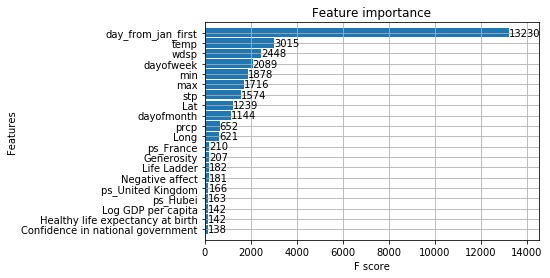

In [48]:
plot = plot_importance(reg, height=0.9, max_num_features=20)

# Use percentage change in the y variable instead of raw numbers

I think another interesting way to look at this might be through percentage change of the y variable. We really care about the percentage change in fatalities from day to day not the total number. This is because we know areas where the infection has been for a longer period of time would automatically have a higher total number, while areas with relatively new infection would have a lower total number of deaths but quite possible a higher percentage change since the virus is spreading more rapidly.

Get the percentage change for each country, using one day lag. Would be interesting to play around with the lag time (periods) to see if this changes the analysis, my first thought would be to change this to 7 day (one week).

In [49]:
y_train = train.groupby(["Country/Region"]).Fatalities.pct_change(periods=1)

There are issues with pct_change function returning NaN when doing percentage change from 0 to 0, so just change these to 0.

In [50]:
y_train = y_train.replace(np.nan, 0)

There are also issues with pct_change function sometimes returning "inf" when going from 0 to 0, so just change these to 0

In [51]:
y_train = y_train.replace(np.inf, 0)

In [52]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [53]:
reg.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

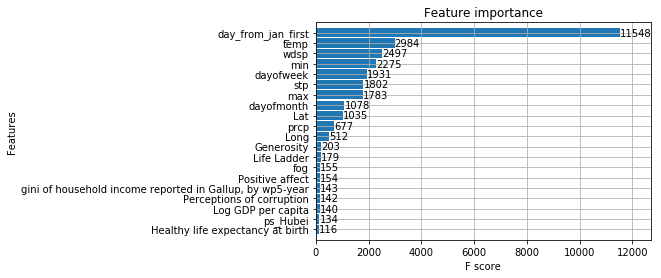

In [54]:
plot = plot_importance(reg, height=0.9, max_num_features=20)

# Change y variable to Confirmed Cases

We will use the same train data as above but lets change the y variable to be Confirmed Cases and see if anything changes.

In [55]:
y_train = train["ConfirmedCases"]

In [56]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [57]:
reg.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

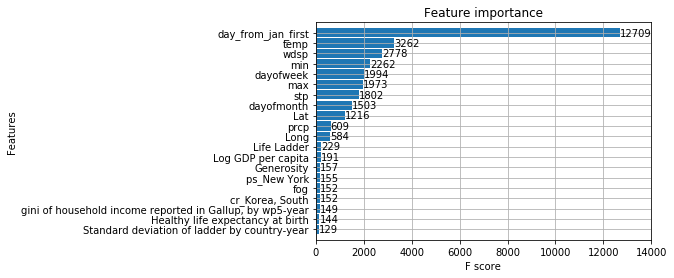

In [58]:
plot = plot_importance(reg, height=0.9, max_num_features=20)

In [59]:
y_train = train.groupby(["Country/Region"]).ConfirmedCases.pct_change(periods=1)

In [60]:
y_train = y_train.replace(np.nan, 0)

In [61]:
y_train = y_train.replace(np.inf, 0)

In [62]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [63]:
reg.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

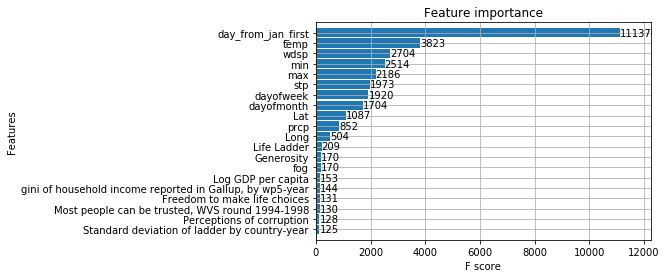

In [64]:
plot = plot_importance(reg, height=0.9, max_num_features=20)

# Try running on test data and submitting results

One thing to note is that fatalities will always go up, so we will want to adjust any prediction that is less than the previous days prediction to be equal to the previous day. Also the same is true with confirmed cases.

In [65]:
y_train = train["ConfirmedCases"]
confirmed_reg = xgb.XGBRegressor(n_estimators=1000)
confirmed_reg.fit(X_train, y_train, verbose=True)
preds = confirmed_reg.predict(X_test)
preds = np.array(preds)
preds[preds < 0] = 0
preds = np.round(preds, 0)

In [66]:
preds = np.array(preds)

In [67]:
preds

array([ 7.,  5., 11., ...,  9.,  7.,  5.], dtype=float32)

In [68]:
submissionOrig = pd.read_csv("../input/covid19-global-forecasting-week-1/submission.csv")

In [69]:
submissionOrig["ConfirmedCases"]=pd.Series(preds)

In [70]:
submissionOrig

,ForecastId,ConfirmedCases,Fatalities
0,1,7.0,1
1,2,5.0,1
2,3,11.0,1
3,4,16.0,1
4,5,22.0,1
...,...,...,...
12207,12208,7.0,1
12208,12209,10.0,1
12209,12210,9.0,1
12210,12211,7.0,1


So one further issue with the predictions is that XGBoost does not know that the predictions should be cumulative, so for each country we always want the predictions to be greater than or equal to the previous days. To fix this issue we should attached the predictions back to the original test dataframe so that we can grouby country/state and then for each grouping we need to make sure that the predicted variable is always equal the previous days prediction or greater.

In [71]:
test = test.join(submissionOrig["ConfirmedCases"])
test["Difference"] = test.groupby(["Country/Region"])["ConfirmedCases"].apply(lambda x: x.shift(1) - x)
for index, row in test.iterrows():
    if index>0:
        if row["Difference"] < 0:
            test.at[index,"ConfirmedCases"] = test.iloc[index-1]["ConfirmedCases"]

In [72]:
submissionOrig["ConfirmedCases"] = test["ConfirmedCases"]
test.drop("ConfirmedCases", axis=1, inplace=True)

In [73]:
y_train = train["Fatalities"]
confirmed_reg = xgb.XGBRegressor(n_estimators=1000)
confirmed_reg.fit(X_train, y_train, verbose=True)
preds = confirmed_reg.predict(X_test)
preds = np.array(preds)
preds[preds < 0] = 0
preds = np.round(preds, 0)
submissionOrig["Fatalities"]=pd.Series(preds)

In [74]:
test = test.join(submissionOrig["Fatalities"])
test["Difference"] = test.groupby(["Country/Region"])["Fatalities"].apply(lambda x: x.shift(1) - x)
for index, row in test.iterrows():
    if index>0:
        if row["Difference"] < 0:
            test.at[index,"Fatalities"] = test.iloc[index-1]["Fatalities"]

In [75]:
submissionOrig["Fatalities"] = test["Fatalities"]
test.drop("Fatalities", axis=1, inplace=True)

In [76]:
submissionOrig

,ForecastId,ConfirmedCases,Fatalities
0,1,7.0,0.0
1,2,5.0,0.0
2,3,38.0,0.0
3,4,16.0,0.0
4,5,543.0,0.0
...,...,...,...
12207,12208,7.0,0.0
12208,12209,241.0,0.0
12209,12210,9.0,0.0
12210,12211,7.0,0.0


In [77]:
submissionOrig.to_csv('submission.csv',index=False)